# Sparkify Project Workspace

In [1]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"
os.environ["JAVA_HOME"] = "/Library/java/JavaVirtualMachines/adoptopenjdk-8.jdk/contents/Home/"

In [2]:
import findspark
findspark.init()

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler)
from pyspark.ml.classification import (
    DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
Load and clean the `mini_sparkify_event_data.json` dataset, checking for invalid or missing data - for example, records without user-ids or session-ids. 

In [5]:
# Read in sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# number of records
df.count()

286500

In [8]:
# check number of missing values in each column
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df.columns]
df.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
# Users without registration are not valid for churn analysis, and thus will be dropped.
df_valid = df.dropna(subset=['registration'])

In [10]:
# check number of missing values for each column again
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df_valid.columns]
df_valid.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



`artist`, `length`, and `song` will be null when a user is visiting pages other than `NextSong`.

In [11]:
df_valid.filter(F.col('artist').isNotNull()).select(
    'page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



# Exploratory Data Analysis
EDA on a small subset of the data with basic manipulations within Spark. 

In [12]:
# number of users
num_users = df_valid.select("userId").dropDuplicates().count()
print(num_users)

225


In [13]:
# number of artists
df_valid.select("artist").dropDuplicates().count()

17656

In [14]:
# auth
df_valid.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [15]:
# itemInSession
df_valid.select("itemInSession").describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|129.85172939949013|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [16]:
# length
df_valid.select("length").describe().show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783722|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



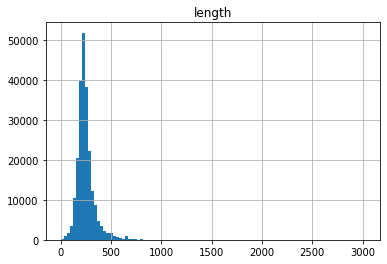

In [17]:
# histogram for length
df_valid.select("length").toPandas().hist(bins=100);

In [18]:
# level
df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [19]:
# location
df.select("location").dropDuplicates().show(10, False)

+--------------------------------------+
|location                              |
+--------------------------------------+
|Gainesville, FL                       |
|Atlantic City-Hammonton, NJ           |
|Deltona-Daytona Beach-Ormond Beach, FL|
|San Diego-Carlsbad, CA                |
|Cleveland-Elyria, OH                  |
|Kingsport-Bristol-Bristol, TN-VA      |
|New Haven-Milford, CT                 |
|Birmingham-Hoover, AL                 |
|Corpus Christi, TX                    |
|Dubuque, IA                           |
+--------------------------------------+
only showing top 10 rows



In [20]:
# method
df.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [21]:
# page
df.select("page").dropDuplicates().show(22, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [22]:
# registration
df.select("registration").show(5)

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
+-------------+
only showing top 5 rows



In [23]:
# songs
df.select("song").show(5, False)

+-----------------------------+
|song                         |
+-----------------------------+
|Rockpools                    |
|Canada                       |
|Time For Miracles            |
|Knocking On Forbidden Doors  |
|Harder Better Faster Stronger|
+-----------------------------+
only showing top 5 rows



In [24]:
# number of songs
df.select("song").drop_duplicates().count()

58481

In [25]:
# status
df.select("status").drop_duplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [26]:
# ts
df.select("ts").show(5)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
+-------------+
only showing top 5 rows



In [27]:
# userAgent
df_valid.select("userAgent").drop_duplicates().show(10, False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


## Define Churn

Define churn events as`Cancellation Confirmation` events.
Create`churn_event` and `churn_user` columns.

In [28]:
# define churn event
flag_churn_event = F.udf(
    lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())

# create churn event column
df_valid = df_valid.withColumn('churn_event', flag_churn_event('page'))

# create churn user column
df_valid = df_valid.withColumn('churn_user', F.max(
    'churn_event').over(Window.partitionBy('userId')))

In [29]:
df_valid.groupBy('churn_user').count().show()

+----------+------+
|churn_user| count|
+----------+------+
|         1| 44864|
|         0|233290|
+----------+------+



In [30]:
44864/(44864 + 233290) * 100

16.129194618808288

## Explore Data
More exploratory data analysis to observe the behavior of users who stayed vs users who churned. The relations between users' attributes such as gender, level, location, and churn events are explored. 
We also explore aggregates on these two groups of users, observing how much of a specific action they experienced such as number of songs played or how many times they visited home page per week.

In [31]:
# number of churn and stayed users
num_churn_users = df_valid.filter(df_valid['churn_user'] == '1').select(
    F.countDistinct('userId')).collect()[0][0]
num_stayed_users = num_users - num_churn_users
print("number of users that churn:", num_churn_users)
print("number of users that stayed:", num_stayed_users)

number of users that churn: 52
number of users that stayed: 173


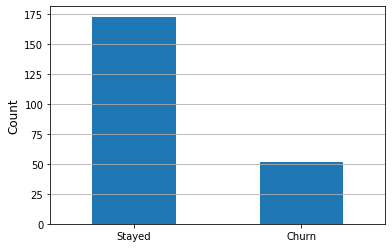

In [32]:
d = {'churns': [num_stayed_users, num_churn_users]}
df_churns = pd.DataFrame(data=d, index=['Stayed', 'Churn'])

ax = df_churns.plot.bar(legend=False)
ax.grid(axis='y')
ax.set_ylabel('Count', fontsize=12)
ax.set_title('')
plt.xticks(rotation=0);
plt.savefig('churns')

In [33]:
# create datetime columns for registration and timestamp
df_valid = df_valid.withColumn(
    'registration_dt', (F.col('registration')/1000).cast(T.TimestampType()))
df_valid = df_valid.withColumn(
    'dt', (F.col('ts')/1000).cast(T.TimestampType()))

In [34]:
# example of churn by `Cancellation Confirmation`
df_valid.select('userId', 'firstName', 'page', 'dt', 'level').where((df_valid['userId'] == 73) & (
    df_valid['page'] == 'Cancellation Confirmation')).show(5, False)

+------+---------+-------------------------+-------------------+-----+
|userId|firstName|page                     |dt                 |level|
+------+---------+-------------------------+-------------------+-----+
|73    |Rachel   |Cancellation Confirmation|2018-10-24 12:33:07|paid |
+------+---------+-------------------------+-------------------+-----+



In [35]:
# example of Submit Downgrade`
df_valid.select('userId', 'firstName', 'page', 'dt', 'level').where((df_valid['userId'] == 39) & (
    df_valid['page'] == 'Submit Downgrade')).show(5, False)

+------+---------+----------------+-------------------+-----+
|userId|firstName|page            |dt                 |level|
+------+---------+----------------+-------------------+-----+
|39    |Payton   |Submit Downgrade|2018-11-03 09:29:32|paid |
|39    |Payton   |Submit Downgrade|2018-11-04 12:58:57|paid |
|39    |Payton   |Submit Downgrade|2018-11-16 19:49:48|paid |
+------+---------+----------------+-------------------+-----+



In [36]:
# example of churn by `Submit Downgrade` followed by `Cancellation Confirmation`
df_valid.select('userId', 'firstName', 'page', 'dt', 'level').where((df_valid['userId'] == 103) & (
    (df_valid['page'] == 'Submit Downgrade') | (df_valid['page'] == 'Cancellation Confirmation'))).show(5, False)

+------+---------+-------------------------+-------------------+-----+
|userId|firstName|page                     |dt                 |level|
+------+---------+-------------------------+-------------------+-----+
|103   |Piper    |Submit Downgrade         |2018-10-15 18:56:25|paid |
|103   |Piper    |Cancellation Confirmation|2018-11-04 08:01:31|paid |
+------+---------+-------------------------+-------------------+-----+



### Gender

In [37]:
num_females = df_valid.filter(df_valid['gender'] == 'F').select(
    F.countDistinct('userId')).collect()[0][0]
num_males = num_users - num_females
print("number of females:", num_females)
print("number of males:", num_males)

number of females: 104
number of males: 121


In [38]:
df_gender = df_valid.groupby('gender').sum('churn_event').toPandas()
df_gender['count'] = [num_females, num_males]
df_gender['percent churn'] = df_gender['sum(churn_event)'] / \
    df_gender['count']*100
df_gender.columns = ['gender', 'num_churns', 'count', 'percent churn']
df_gender.set_index('gender')

,num_churns,count,percent churn
gender,,,
F,20,104,19.230769
M,32,121,26.446281


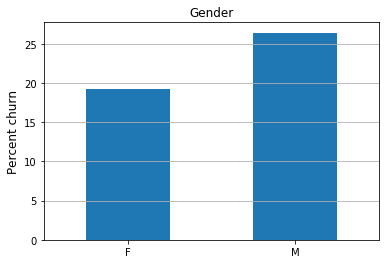

In [39]:
ax = df_gender.plot.bar(x='gender', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_xlabel('')
ax.set_ylabel('Percent churn', fontsize=12)
ax.set_title('Gender')
plt.xticks(rotation=0);
plt.savefig('gender')

### Item In Session

In [40]:
df_item_churn = df_valid.filter(df_valid['churn_user'] == 1).select('itemInSession').toPandas()
df_item_stayed = df_valid.filter(df_valid['churn_user'] == 0).select('itemInSession').toPandas()
df_item = pd.concat([df_item_stayed, df_item_churn], axis=1, ignore_index=True)

In [41]:
df_item.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,233290.0,115.988847,131.150670,0.0,27.0,71.0,159.0,1321.0
1,44864.0,109.232993,122.721709,0.0,26.0,66.0,147.0,889.0


### Level

In [42]:
num_free = df_valid.filter(df_valid['level'] == 'free').select(
    F.countDistinct('userId')).collect()[0][0]
num_paid = df_valid.filter(df_valid['level'] == 'paid').select(
    F.countDistinct('userId')).collect()[0][0]

In [43]:
df_level = df_valid.groupby('level').sum('churn_event').toPandas()
df_level['count'] = [num_free, num_paid]
df_level['percent churn'] = df_level['sum(churn_event)'] / \
    df_level['count'] * 100
df_level.columns = ['level', 'num_churns', 'count', 'percent churn']
df_level.set_index('level')

,num_churns,count,percent churn
level,,,
free,21,195,10.769231
paid,31,165,18.787879


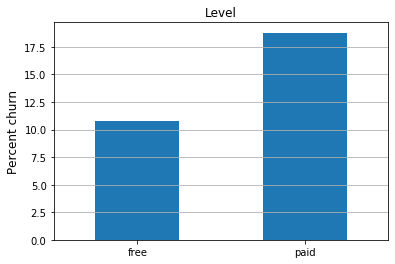

In [44]:
ax = df_level.plot.bar(x='level', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize=12)
ax.set_xlabel('')
ax.set_title('Level')
plt.xticks(rotation=0);
plt.savefig('level')

### Location

In [45]:
df_valid.select("location").show(10, False)

+------------------------------+
|location                      |
+------------------------------+
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Bakersfield, CA               |
|Bakersfield, CA               |
+------------------------------+
only showing top 10 rows



In [46]:
# get state from location
get_state = F.udf(lambda x: x[-2:])

# create state column
df_valid = df_valid.withColumn("state", get_state(df_valid['location']))

In [47]:
df_state_counts = df_valid.select(
    'userId', 'state').dropDuplicates().groupby('state').count().toPandas()

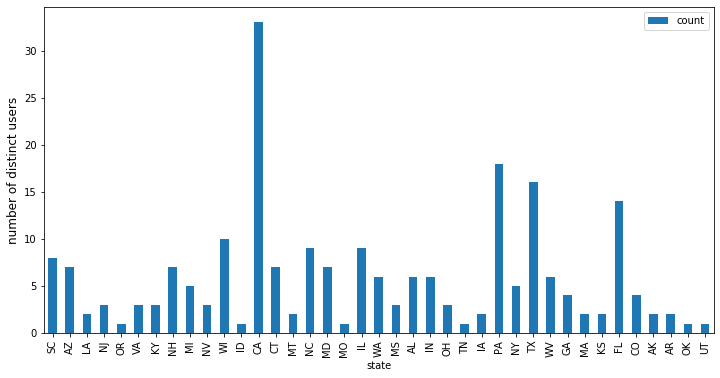

In [48]:
ax = df_state_counts.plot.bar(x='state', y='count',
                              figsize=(12, 6))
ax.set_ylabel('number of distinct users', fontsize=12);

In [49]:
df_state_churns = df_valid.groupby('state').sum('churn_event').toPandas()
df_state_churns.columns = ['state', 'num_churns']

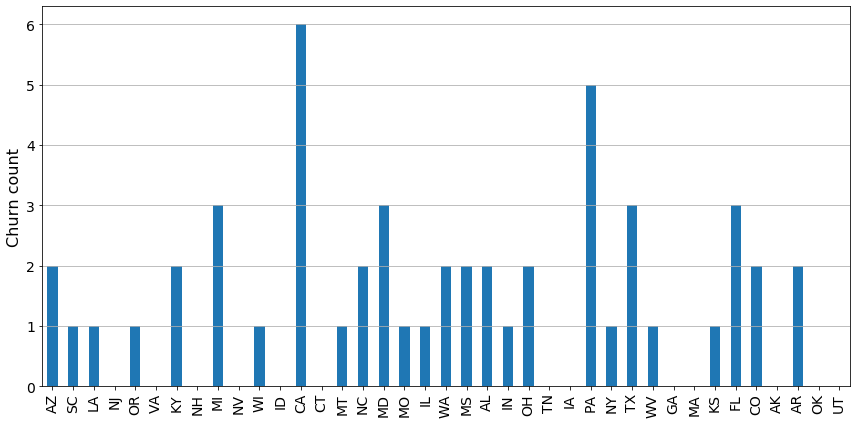

In [50]:
ax = df_state_churns.plot.bar(x='state', y='num_churns', figsize=(12, 6), legend=False)
ax.grid(axis='y')
ax.set_xlabel('')
ax.set_ylabel('Churn count', fontsize=16);
#ax.set_title('State', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('state')

In [51]:
df_state_churns['percent churn'] = df_state_churns['num_churns'] / \
    df_state_counts['count'] * 100

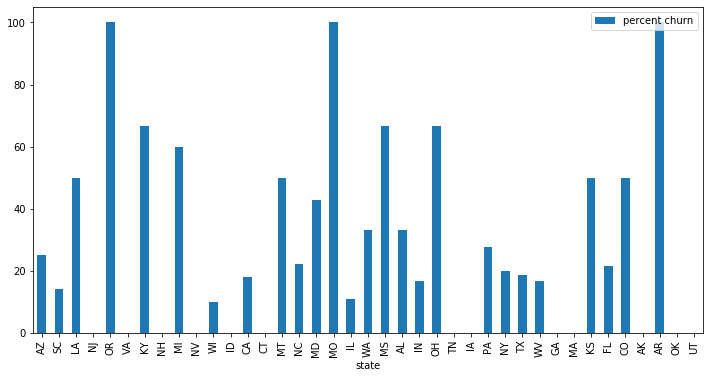

In [52]:
df_state_churns.plot.bar(x='state', y='percent churn', figsize=(12, 6));

### Registration

In [53]:
# find earliest and latest registration dates
start_reg_date = df_valid.agg({'registration_dt': 'min'}).collect()
end_reg_date = df_valid.agg({'registration_dt': 'max'}).collect()
print('registration start date:', str(start_reg_date[0][0]))
print('registration end date:', str(end_reg_date[0][0]))

registration start date: 2018-03-18 08:44:35
registration end date: 2018-11-26 09:49:14


In [54]:
# find earliest and latest dates (from timestamp)
start_date = df_valid.agg({'dt': 'min'}).collect()
end_date = df_valid.agg({'dt': 'max'}).collect()
print('start date:', str(start_date[0][0]))
print('end date:', str(end_date[0][0]))

start date: 2018-09-30 19:01:57
end date: 2018-12-02 19:11:16


In [55]:
# number of days since registration
df_valid = df_valid.withColumn("days_since_reg", F.max(
    F.datediff('dt', 'registration_dt')).over(Window.partitionBy('userId')))

In [56]:
df_valid.select('days_since_reg').describe().show()

+-------+-----------------+
|summary|   days_since_reg|
+-------+-----------------+
|  count|           278154|
|   mean|88.91284684023958|
| stddev| 40.4933547852528|
|    min|                0|
|    max|              256|
+-------+-----------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc186eba410>]],
      dtype=object)

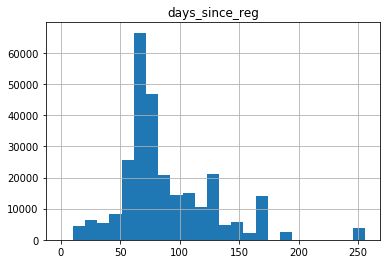

In [57]:
df_valid.select('days_since_reg').toPandas().hist(bins=25)

In [58]:
df_days_stayed = df_valid.filter(
    df_valid['churn_user'] == 0).select('days_since_reg').toPandas()
df_days_churn = df_valid.filter(
    df_valid['churn_user'] == 1).select('days_since_reg').toPandas()
df_reg_days = pd.concat([df_days_stayed, df_days_churn], axis=1, ignore_index=True)
df_reg_days.columns = ['stayed', 'churn']

In [59]:
df_reg_days.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stayed,233290.0,92.999773,38.790168,0.0,67.0,77.0,115.0,256.0
churn,44864.0,67.661087,42.466799,5.0,42.0,56.0,80.0,188.0


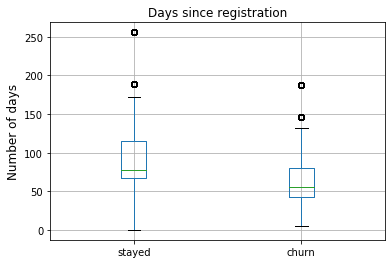

In [60]:
ax = df_reg_days.boxplot()
ax.set_ylabel('Number of days', fontsize=12)
ax.set_title('Days since registration');
plt.savefig('days_since_registration')

### Timestamp

In [61]:
get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).hour, T.IntegerType())
get_day = F.udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).day, T.IntegerType())
get_month = F.udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).month, T.IntegerType())

In [62]:
df_valid = df_valid.withColumn('hour', get_hour(F.col('ts')))\
    .withColumn('day', get_day(F.col('ts')))\
    .withColumn('month', get_month(F.col('ts')))

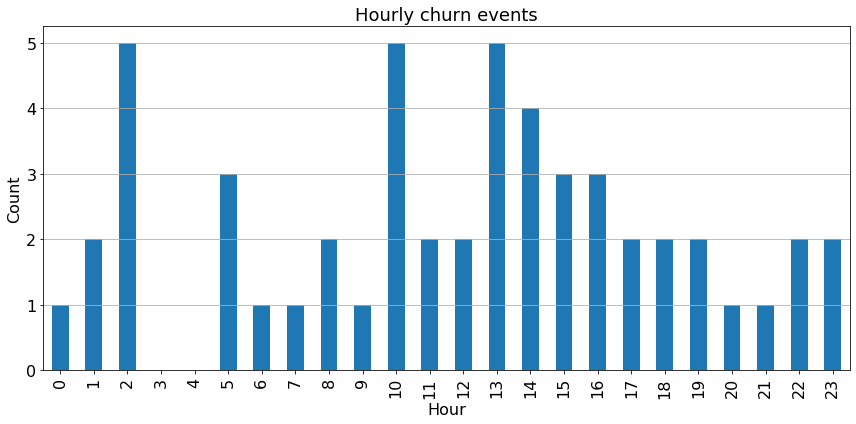

In [63]:
ax = df_valid.groupBy('hour').sum('churn_event').sort('hour').toPandas(
).plot.bar(x='hour', y='sum(churn_event)', figsize=(12, 6), legend=False)
ax.grid(axis='y')
ax.set_xlabel('Hour', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Hourly churn events', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig('hourly_churn_events')

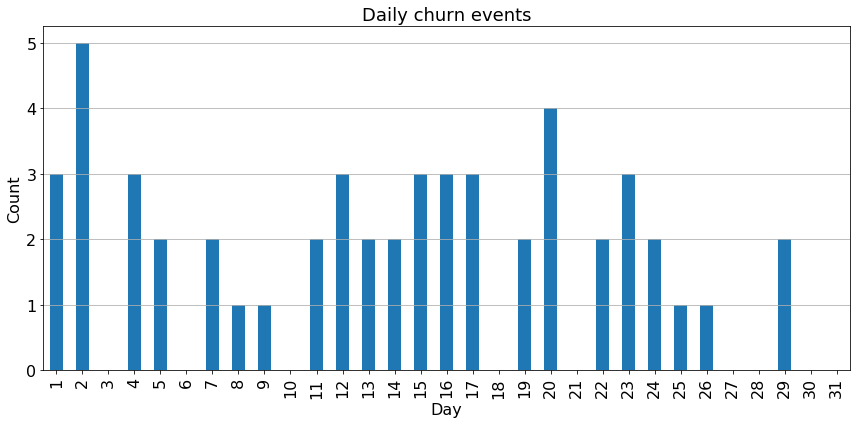

In [64]:
ax = df_valid.groupBy('day').sum('churn_event').sort('day').toPandas(
).plot.bar(x='day', y='sum(churn_event)', figsize=(12, 6), legend=False)
ax.grid(axis='y')
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Daily churn events', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig('daily_churn_events')

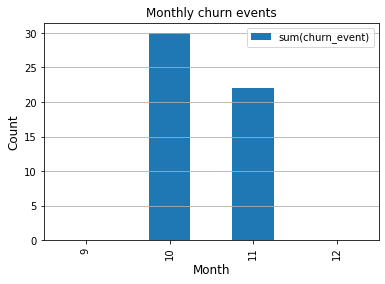

In [65]:
ax = df_valid.groupBy('month').sum('churn_event').sort(
    'month').toPandas().plot.bar(x='month', y='sum(churn_event)')
ax.grid(axis='y')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Monthly churn events');
plt.savefig('montly_churn_events')

### Song

In [66]:
# time window to find number of songs played in a week
def days(x): 
    """Return time in seconds for the input time in days."""
    time_in_seconds = x * 86400
    return time_in_seconds


windowval = (
    Window.partitionBy("userId")
    .orderBy(F.col("ts")/1000)
    .rangeBetween(-days(7), 0)
)

In [67]:
# number of songs played in a week
df_valid = df_valid.withColumn("num_songs", F.count("song").over(windowval))

In [68]:
# check
df_valid.select('userId', 'dt', 'song', 'num_songs', 'churn_event',
                'churn_user').where(df_valid['userId'] == 32).show(200)

+------+-------------------+--------------------+---------+-----------+----------+
|userId|                 dt|                song|num_songs|churn_event|churn_user|
+------+-------------------+--------------------+---------+-----------+----------+
|    32|2018-10-03 10:01:37|Beyond The Beyond...|        1|          0|         1|
|    32|2018-10-03 10:05:34|       Paradise City|        2|          0|         1|
|    32|2018-10-03 10:12:20|           Alejandro|        3|          0|         1|
|    32|2018-10-03 10:12:45|                null|        3|          0|         1|
|    32|2018-10-03 10:16:54|        Luv U Better|        4|          0|         1|
|    32|2018-10-03 10:16:55|                null|        4|          0|         1|
|    32|2018-10-03 10:20:56|My Life Would Suc...|        5|          0|         1|
|    32|2018-10-03 10:21:08|                null|        5|          0|         1|
|    32|2018-10-03 10:24:27|Jamaica Roots II(...|        6|          0|         1|
|   

In [69]:
def make_boxplot(df, col_name):
    """Return boxplot of stayed and churn for the attribute col_name of the dataframe df."""
    df_stayed = df.filter(df['churn_user'] == 0).select(
        col_name).toPandas()
    df_churn = df.filter(df['churn_user'] == 1).select(
        col_name).toPandas()

    df = pd.concat([df_stayed, df_churn], axis=1, ignore_index=True)
    df.columns = ['stayed', 'churn']

    statistics = df.describe().transpose()

    ax = df.boxplot()
    ax.set_title(col_name + ' per week', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

    return statistics, ax

(           count        mean         std  min    25%    50%    75%     max
 stayed  233290.0  327.931956  291.710516  0.0  106.0  250.0  471.0  1739.0
 churn    44864.0  322.473676  276.914138  0.0  102.0  240.0  460.0  1229.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc188543950>)

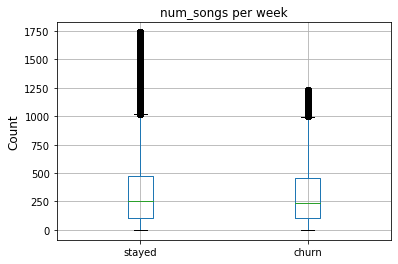

In [70]:
make_boxplot(df_valid, 'num_songs')

### Artist

In [71]:
# number of distinct artists played in a week
df_valid = df_valid.withColumn("num_artists", F.size(
    F.collect_set("artist").over(windowval)))

(           count        mean         std  min    25%    50%    75%     max
 stayed  233290.0  276.899246  221.271778  0.0  101.0  227.0  403.0  1206.0
 churn    44864.0  273.729494  215.208273  0.0   98.0  220.0  396.0   916.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc18707c450>)

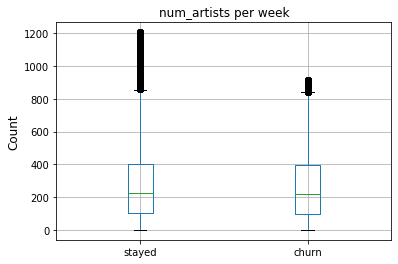

In [72]:
make_boxplot(df_valid, 'num_artists')

### Session

In [73]:
# number of sessions in a week
df_valid = df_valid.withColumn(
    'num_sessions', F.count('sessionId').over(windowval))

(           count        mean         std  min    25%    50%    75%     max
 stayed  233290.0  394.943024  346.035217  1.0  131.0  303.0  566.0  2044.0
 churn    44864.0  389.186831  324.166695  1.0  130.0  298.0  557.0  1488.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc17ef7c090>)

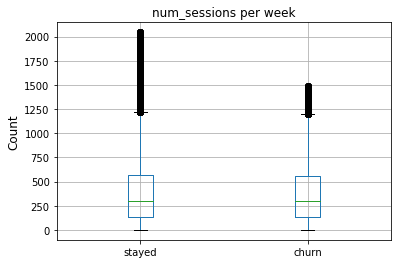

In [74]:
make_boxplot(df_valid, 'num_sessions')

### Status

In [75]:
df_valid.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [76]:
# flag the status 'redirect' and 'not found'
flag_redirect = F.udf(lambda x: 1 if x == 307 else 0, T.IntegerType())
flag_not_found = F.udf(lambda x: 1 if x == 404 else 0, T.IntegerType())

In [77]:
# create redirect and page_not_found columns
df_valid = df_valid.withColumn(
    "redirect", flag_redirect(df_valid['status']))
df_valid = df_valid.withColumn(
    "page_not_found", flag_not_found(df_valid['status']))

In [78]:
df_valid.groupBy('churn_user').sum('redirect').show()

+----------+-------------+
|churn_user|sum(redirect)|
+----------+-------------+
|         1|         3695|
|         0|        19489|
+----------+-------------+



In [79]:
df_valid.groupBy('churn_user').sum('page_not_found').show()

+----------+-------------------+
|churn_user|sum(page_not_found)|
+----------+-------------------+
|         1|                 32|
|         0|                220|
+----------+-------------------+



In [80]:
df_valid.filter(df_valid['status'] == '307').select(
    F.sum("churn_event")).show()

+----------------+
|sum(churn_event)|
+----------------+
|               0|
+----------------+



In [81]:
df_valid.filter(df_valid['status'] == '200').select(
    F.sum("churn_event")).show()

+----------------+
|sum(churn_event)|
+----------------+
|              52|
+----------------+



### Page

In [82]:
df_valid.groupby('page').count().show(22, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



In [83]:
# create aggregate features from the column 'page'

pages = ['Thumbs Down', 'Thumbs Up', 'Home', 'Roll Advert',
         'Logout', 'Add to Playlist', 'Add Friend', 'Error']

for page in pages:
    flag_page = F.udf(lambda x: 1 if x == page else 0, T.IntegerType())
    df_valid = df_valid.withColumn('flag', flag_page('page'))
    df_valid = df_valid.withColumn(
        'num_' + page, F.sum('flag').over(windowval)).drop('flag')

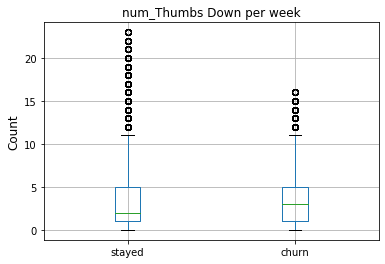

In [84]:
make_boxplot(df_valid, 'num_Thumbs Down')
plt.savefig('num_Thumbs_Down')

(           count      mean        std  min  25%   50%   75%   max
 stayed  233290.0  17.99159  16.784588  0.0  5.0  13.0  26.0  95.0
 churn    44864.0  16.06941  14.271955  0.0  5.0  12.0  24.0  69.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc184447410>)

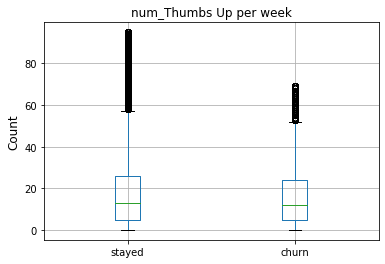

In [85]:
make_boxplot(df_valid, 'num_Thumbs Up')

(           count       mean        std  min  25%   50%   75%   max
 stayed  233290.0  13.683514  11.509309  0.0  5.0  11.0  19.0  62.0
 churn    44864.0  13.979471  10.738320  0.0  5.0  11.0  21.0  55.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc18796e310>)

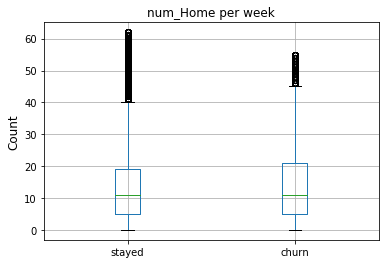

In [86]:
make_boxplot(df_valid, 'num_Home')

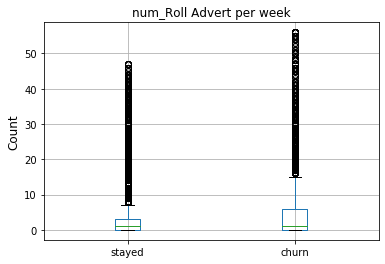

In [87]:
make_boxplot(df_valid, 'num_Roll Advert')
plt.savefig('num_Roll_Advert')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  4.208282  4.198681  0.0  1.0  3.0  6.0  25.0
 churn    44864.0  4.550152  4.018905  0.0  1.0  4.0  7.0  18.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc184761250>)

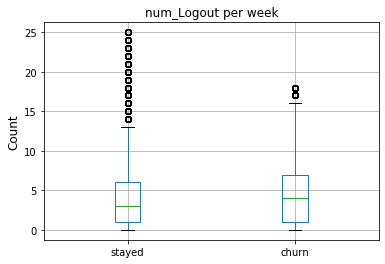

In [88]:
make_boxplot(df_valid, 'num_Logout')

(           count      mean       std  min  25%  50%   75%   max
 stayed  233290.0  9.494826  9.315929  0.0  3.0  7.0  14.0  61.0
 churn    44864.0  9.321616  8.737732  0.0  3.0  6.0  14.0  47.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc183fbced0>)

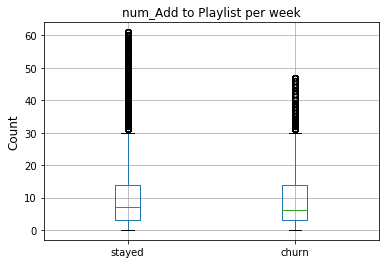

In [89]:
make_boxplot(df_valid, 'num_Add to Playlist')

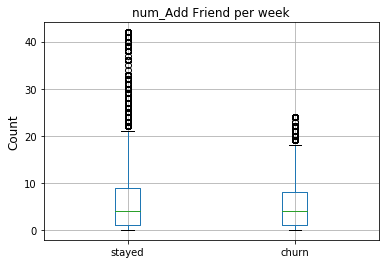

In [90]:
make_boxplot(df_valid, 'num_Add Friend')
plt.savefig('num_Add_Friend')

(           count      mean       std  min  25%  50%  75%  max
 stayed  233290.0  0.317665  0.600159  0.0  0.0  0.0  1.0  4.0
 churn    44864.0  0.231589  0.496960  0.0  0.0  0.0  0.0  2.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc16c289710>)

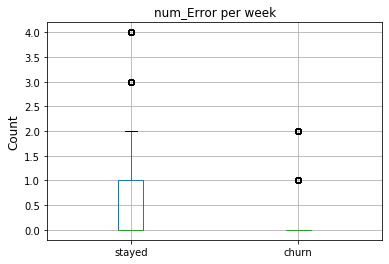

In [91]:
make_boxplot(df_valid, 'num_Error')

In [92]:
df_temp = df_valid.select(
    'churn_user',
    'itemInSession',
    'length',
    'days_since_reg',
    'hour',
    'day',
    'month',
    'num_songs',
    'num_artists',
    'num_sessions',
    'num_Thumbs Down',
    'num_Thumbs Up',
    'num_Home',
    'num_Roll Advert',
    'num_Logout',
    'num_Add to Playlist',
    'num_Add Friend',
    'num_Error'
).toPandas()

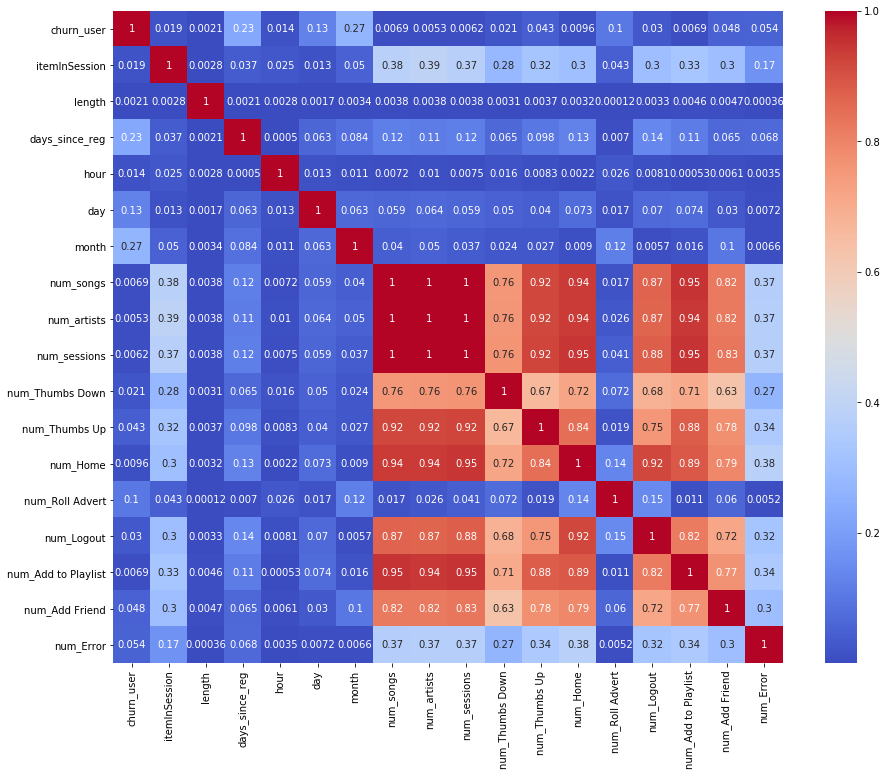

In [93]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_temp.corr().abs(), annot=True, cmap='coolwarm');
#plt.ylim(12, 0)

Highly correlated features will be dropped to avoid multicollinearity. 

In [94]:
df_temp_2 = df_valid.select(
    'churn_user',
    'itemInSession',
    'days_since_reg',
    'hour',
    'day',
    'month',
    'num_Thumbs Down',
    'num_Roll Advert',
    'num_Add Friend',
    'num_Error'
).toPandas()

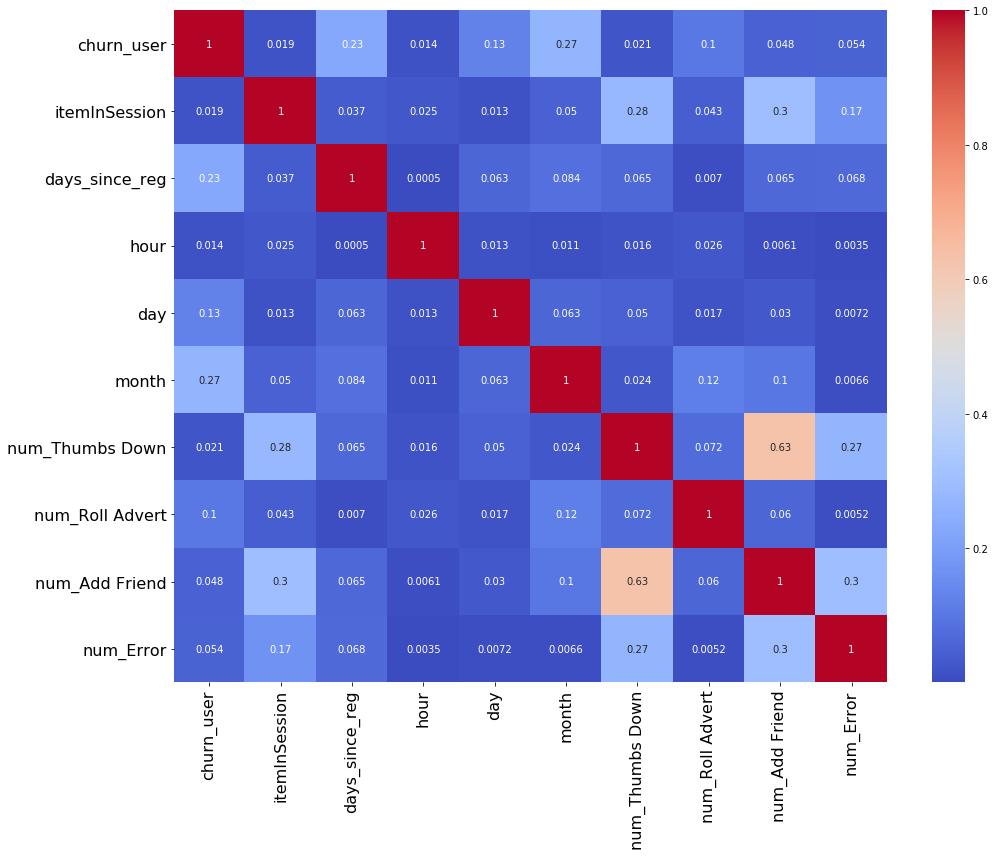

In [95]:
plt.figure(figsize=(15, 12))
ax = sns.heatmap(df_temp_2.corr().abs(), annot=True, cmap='coolwarm');
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig('heatmap')

# Feature Engineering
Data preprocessing and preparing machine learning pipelines for logistic regression, random forest and gradient boosted trees models. Stages for the pipelines include indexing and one-hot encoding categorical columns, transforming columns into a single vector column, and scaling the values of the features into the range from 0 to 1.

In [96]:
def clean_data(df):
    """Return valid data by dropping missing values in registration."""
    df_clean = df.dropna(subset=['registration']).na.fill(
        0, subset=['length'])

    return df_clean


def is_churn(df):
    """Return dataframe with labels for churn users."""

    flag_churn_event = F.udf(
        lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())

    df_new = df.withColumn(
        'churn_event', flag_churn_event(F.col('page')))

    df_new = df_new.withColumn('label', F.max(
        'churn_event').over(Window.partitionBy('userId')))

    return df_new


def registration_days(df):
    """Return the number of days since registration."""

    df_new = df.withColumn('registration date', (F.col(
        'registration')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn(
        'date', (F.col('ts')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn('days_since_registration', (F.datediff(
        'date', 'registration date'))).drop('date', 'registration date')

    return df_new


def timestamp(df):
    """Return dataframe with hour, day, and month."""

    get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).hour, T.IntegerType())
    get_day = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).day, T.IntegerType())
    get_month = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).month, T.IntegerType())

    df_new = df.withColumn('hour', get_hour(F.col('ts'))).withColumn(
        'day', get_day(F.col('ts'))).withColumn('month', get_month(F.col('ts')))

    return df_new

# time window to find aggregate values per day


def days(x):
    """Return time in seconds for the input time in days."""
    time_in_seconds = x * 86400
    return time_in_seconds


windowval = (
    Window.partitionBy("userId")
    .orderBy(F.col("ts")/1000)
    .rangeBetween(-days(7), 0)
)


# create aggregate features from the column 'page'
pages = ['Thumbs Down', 'Roll Advert', 'Add Friend', 'Error']


def aggregate_features(df):
    """Return selected aggregate features from page."""
    df_new = df

    for page in pages:

        flag_page = F.udf(lambda x: 1 if x ==
                          page else 0, T.IntegerType())
        df_new = df_new.withColumn('flag', flag_page('page'))
        df_new = df_new.withColumn(
            'num_' + page, F.sum('flag').over(windowval)).drop('flag')

    return df_new


def retrive_state(df):
    """Return dataframe with states retrived from locations."""
    df_new = df
    get_state = F.udf(lambda x: x[-2:])
    df_new = df_new.withColumn("state", get_state(
        df_new['location'])).drop('location')

    return df_new


ignore_list = ['artist',
               'auth',
               'firstName',
               'length',
               'lastName',
               'method',
               'page',
               'registration',
               'sessionId',
               'song',
               'ts',
               'userAgent',
               'userId',
               'churn_event',
               ]


def ignore(df, ignore_list):
    """Remove unnecessary feature columns."""
    df_new = df.drop(*ignore_list)

    return df_new


def preprocess_data(df):
    """
      1. Remove invalid data.
      2. Add churn event and churn user labels.
      3. Add number of days since registration.
      4. Add hour, day, and month.
      5. Add aggregate features.
      6. Get state from location.
      7. Remove unnecessary feature columns.
    """

    df_clean = clean_data(df)
    df_churn = is_churn(df_clean)
    df_reg_days = registration_days(df_churn)
    df_timestamp = timestamp(df_reg_days)
    df_aggregate = aggregate_features(df_timestamp)
    df_state = retrive_state(df_aggregate)
    df_processed = ignore(df_state, ignore_list)

    return df_processed


df_processed = preprocess_data(df).cache()
df.unpersist()


# Prepare stages for ML Pipeline
stages = []

# Index and one-hot encode categorical columns
cat_columns = ['gender', 'level', 'status', 'state', 'month']

for column in cat_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column+'_index')
    encoder = OneHotEncoderEstimator(
        inputCols=[indexer.getOutputCol()], outputCols=[column + '_vect'])

    stages += [indexer, encoder]

num_columns = [
    'itemInSession',
    'days_since_registration',
    'hour',
    'day',
    'num_Thumbs Down',
    'num_Roll Advert',
    'num_Add Friend',
    'num_Error'
]

# Transform columns into a single vector column.
vect_assembler_inputs = [c + '_vect' for c in cat_columns] + num_columns
assembler = VectorAssembler(
    inputCols=vect_assembler_inputs, outputCol="features")

stages += [assembler]

# Rescale  each feature into the range from 0 to 1.
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

stages += [scaler]

# Instantiate classifiers
lr = LogisticRegression(labelCol='label', featuresCol='scaled_features')

rfc = RandomForestClassifier(
    labelCol='label', featuresCol='scaled_features')

gbt = GBTClassifier(labelCol='label', featuresCol='scaled_features')

# Set stages for classifiers
stages_lr = stages + [lr]
stages_rfc = stages + [rfc]
stages_gbt = stages + [gbt]

In [97]:
print('df_processed shape: {}, {}'.format(df_processed.count(), len(df_processed.columns)))

df_processed shape: 278154, 14


In [98]:
df_processed.columns

['gender',
 'itemInSession',
 'level',
 'status',
 'label',
 'days_since_registration',
 'hour',
 'day',
 'month',
 'num_Thumbs Down',
 'num_Roll Advert',
 'num_Add Friend',
 'num_Error',
 'state']

# Modeling
Split the full dataset into train and test datasets, set stages for pipelines and train models.

In [99]:
# Split the full dataset into train and test sets
train, test = df_processed.randomSplit([0.8, 0.2], seed=42)

In [100]:
# set pipelines
pipeline_lr = Pipeline().setStages(stages_lr)
pipeline_rfc = Pipeline().setStages(stages_rfc)
pipeline_gbt = Pipeline().setStages(stages_gbt)

In [101]:
# train models
model_lr = pipeline_lr.fit(train)
model_rfc = pipeline_rfc.fit(train)
model_gbt = pipeline_gbt.fit(train)

# Model Evaluation

In [102]:
# Instantiate evaluators
f1_eval = MulticlassClassificationEvaluator(
    labelCol='label', metricName='f1')  # F1 score evaluator

AUC_eval = BinaryClassificationEvaluator(
    labelCol='label', metricName="areaUnderROC")  # AUC evaluator

In [103]:
def evaluate_model(model):
    """ Return f1 and AUC scores of the model evaluated with test data."""
    preds = model.transform(test)
    f1 = f1_eval.evaluate(preds)
    AUC = AUC_eval.evaluate(preds)
    
    return f1, AUC

In [104]:
lr_f1, lr_AUC = evaluate_model(model_lr)
print('Logistic Regression')
print('F1 =', lr_f1)
print('AUC =', lr_AUC)

Logistic Regression
F1 = 0.8958794536439916
AUC = 0.9140674684032412


In [105]:
rfc_f1, rfc_AUC = evaluate_model(model_rfc)
print('Random Forest Classifier')
print('F1 =', rfc_f1)
print('AUC =', rfc_AUC)

Random Forest Classifier
F1 = 0.8185147095822369
AUC = 0.9018213197538963


In [106]:
gbt_f1, gbt_AUC = evaluate_model(model_gbt)
print('Gradient-boosted Tree Classifier')
print('F1 =', gbt_f1)
print('AUC =', gbt_AUC)

Gradient-boosted Tree Classifier
F1 = 0.9307450445480091
AUC = 0.9565213897443612


In [107]:
# create a dataframe for metrics
d = {'Classifier': ['LogisticRegression', 'RandomForestClassifier','GBTClassifier'],
     'F1': [lr_f1, rfc_f1, gbt_f1], 
     'AUC': [lr_AUC, rfc_AUC, gbt_AUC]}

df_metrics = pd.DataFrame(data=d)

In [108]:
df_metrics

,Classifier,F1,AUC
0,LogisticRegression,0.895879,0.914067
1,RandomForestClassifier,0.818515,0.901821
2,GBTClassifier,0.930745,0.956521


### Model Selection
Hyperparameter tuning for GBTClassifier using three-fold cross validation.

In [109]:
# Create param_grid for Cross Validation
param_grid = (ParamGridBuilder()
              .addGrid(gbt.stepSize, [0.1, 0.5])
              .addGrid(gbt.maxIter, [20, 32])
              .build())

In [110]:
pipeline = Pipeline().setStages(stages)

# Fit the pipeline with training data and transform train and test datasets
train_prep = pipeline.fit(train).transform(train).cache()
test_prep =pipeline.fit(train).transform(test).cache()

In [111]:
cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=param_grid,
    evaluator=f1_eval,
    numFolds=2)

cv_model = cv.fit(train_prep)

In [ ]:
# extract best model's parameters
cv_model.bestModel.extractParamMap()

In [ ]:
cv_preds = cv_model.transform(test_prep)

In [ ]:
cv_f1 = f1_eval.evaluate(cv_preds)
print('best_model F1 score:', cv_f1)

#### Classification Report

In [ ]:
cv_preds_pd = cv_preds.toPandas()
labels = cv_preds_pd['label']
predictions = cv_preds_pd['prediction']
probabilities = cv_preds_pd['probability'].apply(lambda x: x[1]).values

In [ ]:
print(classification_report(labels, predictions))

In [ ]:
confusion_matrix(labels, predictions)

In [ ]:
# Create ROC curve
fpr, tpr, _ = roc_curve(labels, probabilities)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');